In [2]:
!pip install rawpy imageio scikit-image scipy bitstream opencv-python # 安装所需要的包

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



# Home Work 3 - Image Processing Programing 
## 1.去马赛克（Demosiacing）
******
数码相机上的每个像素都是有一个光电传感器，用以将接收到的光强转化为对应的电信号。由于光电二极管是只支持单颜色的装置，不能区分不同波长的光线。因此，工程师在相机感应器的上部装上了一套镶嵌式的颜色滤镜，一个彩色滤镜阵列（color filtering array, CFA），以便让感应器区分组成可见光的红、绿、蓝三种基本颜色。其中，最常见的是拜尔阵列（Bayer filter）：
<div style="text-align: center">
<img src="./imgs/bayer.png" width = "600"/>
</div>
由于人眼对黄绿色波长的亮度感受最为明显，在拜尔阵列中，设计的绿色感光器的数量两倍于红色和蓝色感光器数量。尽管拜尔阵列是一种相对固定的排列方式，但是根据排列顺序（相位）的不同，拜尔阵列也可以被分为BGGR, RGBG,GRBG,和RGGB几种不同的排列格式。可以看到，对于每一个像素，仅有一个通道的彩色信号被记录下来，得到的图像在局部上具有一种马赛克感。为了恢复像素所丢失的彩色信号，我们可以通过临近有效像素的插值来实现，这一步操作通常被称为去马赛克（demosaicing）。以下我们将模拟这一原始图像信号，并进行去马赛克操作。

### 1.1 生成模拟的Bayer图像
通过通道分离采样的方式模拟的拜尔采样图像，<font color=red>请同学将文件夹中的'sample.jpg'替换为自己拍摄到的图片</font>，并运行下方的脚本以生成一个模拟的RGGB格式原始Bayer图像。

In [3]:
import numpy as np
import rawpy, imageio, cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from bitstream import BitStream
def Bayer(img_rgb):
    # 模拟bayer格式图像
    # 输入： img_rgb: RGB图像, type=numpy.array, shape=(H,W,3),三通道依次为R,G,B
    # 输出： bayer: 模拟的bayer图像，type=numpy.array, shape=(H,W)
    mask = np.zeros(img_rgb.shape)
    #Red channel
    mask[:, :, 0][::2, ::2] = 1
    #Green channel
    mask[:, :, 1][::2, 1::2] = 1
    mask[:, :, 1][1::2, ::2] = 1
    #Blue channel
    mask[:, :, 2][1::2, 1::2] = 1
    #calculate the bayer image
    bayer = mask * img_rgb
    bayer = bayer.max(axis=2).astype(np.uint8)
    return bayer 

img_rgb = imageio.imread('sample.jpg') # 请同学们更换成自己拍摄的图片
img_bayer = Bayer(img_rgb)

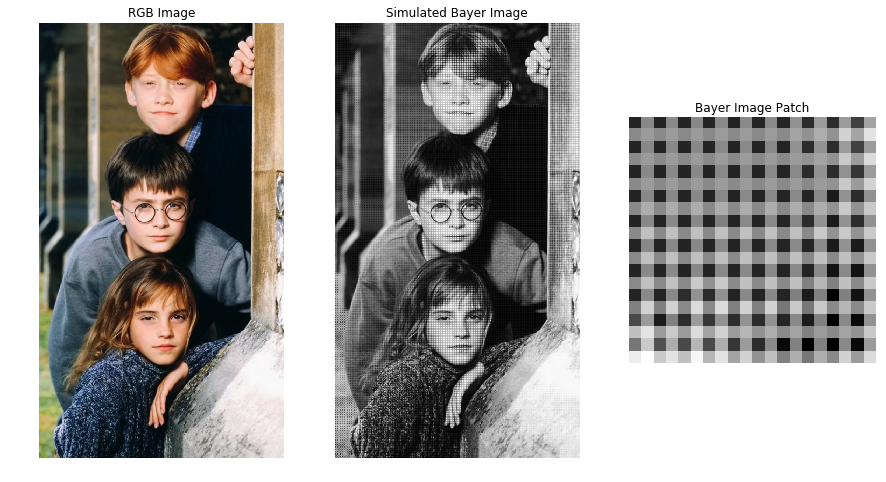

RGB shape: (1246, 700, 3)   Bayer shape: (1246, 700)


In [7]:
# 图片可视化
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(img_rgb)
ax.set_title('RGB Image'); ax.axis('off')
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(img_bayer,cmap='gray'); ax.axis('off')
ax.set_title('Simulated Bayer Image')
ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(img_bayer[:20,:20],cmap='gray'); ax.axis('off')
ax.set_title('Bayer Image Patch')
plt.show()

print('RGB shape:',img_rgb.shape,'  Bayer shape:',img_bayer.shape)

### 1.2 对模拟的bayer图像去马赛克
请同学完成函数 demosiacing,使用线性插值的方式。如果某个像素没有值，则其值应由以它为中心的邻近`3*3`图像块中有值部分的均值决定。例如对红色图像，不同位置的插值计算有所不同，绿色通道与红色和蓝色也不同。

<div style="text-align: center">
<img src="./imgs/demosac_sample.png" width = "600"/>
</div>

Hint: 试着将线性插值以[卷积](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)的形式写出来，可以更加高效

In [8]:
# 请完成这部分代码    （10分）

def demosiacing(img_bayer):
    # 输入： img_bayer: Bayer图像，type=numpy.array, shape=(H,W)
    # 输出： img_rgb: 去马赛克的RGB图像，type=numpy.array, shape=(H,W,3),三通道依次为R,G,B
    
    return img_rgb

对demosiacing函数的效果进行测试，你的code能否正确恢复出三通道的RGB图像呢？ 分别从直观视觉上和数值上进行衡量，其中PSNR是峰值信噪比，值越大表示图像越接近，正确的恢复其参考值应在大约在30或以上；SSIM衡量结构相似性，越接近1效果越好

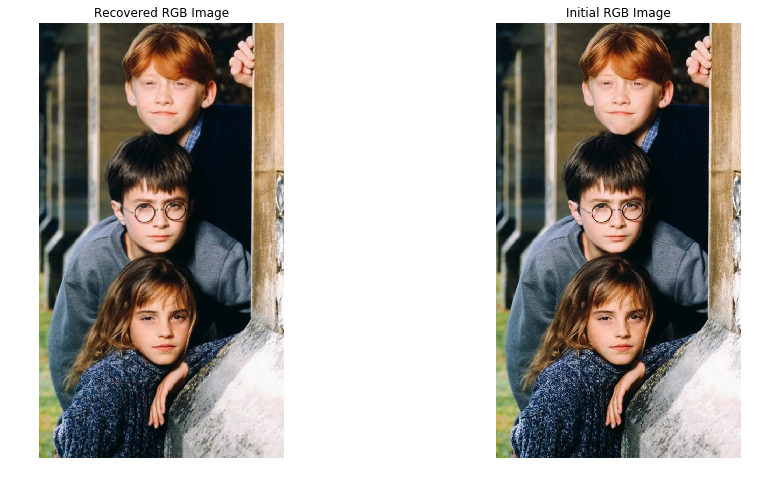

evaluation of reconstruction are measured by comapring reconstruted and initial RGB image 
 PSNR: 31.63005527278631   SSIM: 0.9741425937787404


In [5]:
# 对demosiacing函数的效果进行测试，能否正确恢复出三通道的RGB图像呢？

rec_rgb = (demosiacing(img_bayer/255)*255).astype(np.uint8)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(rec_rgb)
ax.set_title('Recovered RGB Image'); ax.axis('off')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(img_rgb); ax.axis('off')
ax.set_title('Initial RGB Image')
plt.show()


psnr = peak_signal_noise_ratio(img_rgb,rec_rgb)
ssim = structural_similarity(img_rgb,rec_rgb,multichannel=True)
print('evaluation of reconstruction are measured by comapring reconstruted and initial RGB image \n PSNR:',psnr, '  SSIM:',ssim)

既然已经可以完美对模拟的Bayer图像进行去马赛克得到RGB图像，让我们对真实拍到的原始格式的图像进行处理。文件夹中有助教用手机端Lightroom拍到的原始格式照片‘raw.dng’（dng为adobe开发的一种通用raw格式）。我们使用rawpy库对文件进行读取，并试着用demosiacing函数进行处理：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


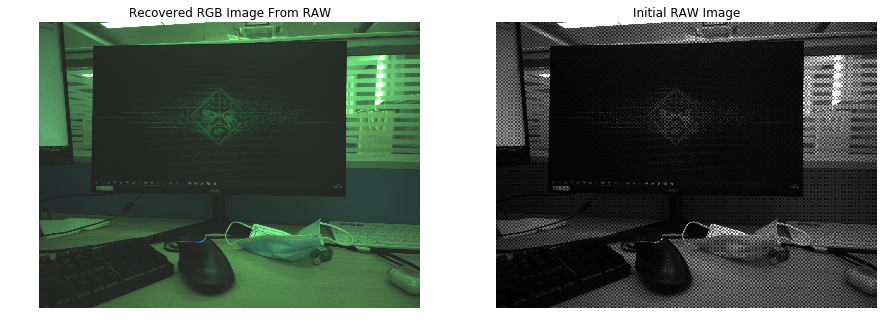

In [10]:
raw = rawpy.imread('raw.dng') # 读入raw文件,包括数据与描述性文件
raw_image = raw.raw_image  # 读出原始像感器采集到的图片,返回一个大小是(H,W),数据类型为uint16的numpy.array,有效范围为10bit

rec_raw = demosiacing(raw_image/4095)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(rec_raw)
ax.set_title('Recovered RGB Image From RAW'); ax.axis('off')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(raw_image,cmap='gray'); ax.axis('off')
ax.set_title('Initial RAW Image')
plt.show()


Q: 你得到了一副怎样的结果，是否符合你的预期？如果不符合预期，你猜测可能的原因是什么？ （2分）

A： 

In [ ]:
## 可以添加任何代码验证猜想并进行调试


In [ ]:
## （加分项,和最后的附加分总和最高可加15分）使用不同的去马赛克方法，并说明有什么样的优势

# 2 完整的RAW图像处理流程
******
如上例所示，RAW图像的后处理并不仅仅是去马赛克，完整的RAW图像处理流程包括线性化、白平衡、色彩空间校正以及亮度和γ校正，这些步骤都需要从dng文件中获取拍摄时所记录下来的更多描述性信息，首先来了解一下这些信息。
<div style="text-align: center">
<img src="./imgs/RAW_processing.png" width = "600"/>
</div>

In [13]:
camera_wb = np.asarray(raw.camera_whitebalance)  # 相机白平衡
tone_curve = raw.tone_curve                      # 相机色调曲线
black_level = raw.black_level_per_channel[0]     # 黑色阈值
white_level = raw.white_level                    # 白色阈值
color_matrix = raw.color_matrix                  # 彩色空间校正矩阵
color_desc = raw.color_desc                      # 对彩色滤波片的描述
raw_pattern = raw.raw_pattern                    # 对彩色滤波片排列的描述
num_colors = raw.num_colors                      # 彩色的数量


print("camera_wb:",camera_wb)
print("black_level:",black_level, "   white_level:",white_level)
print("color_matrix:\n",color_matrix)
print("raw_pattern:\n",raw_pattern)
print("color_desc:",color_desc,'num_colors',num_colors)

camera_wb: [2.28637791 1.         2.06127763 0.        ]
black_level: 528    white_level: 4095
color_matrix:
 [[ 1.301222   -0.11556344 -0.18565856  0.        ]
 [-0.19953975  1.5152885  -0.3157487   0.        ]
 [-0.01639105 -0.4719361   1.4883271   0.        ]]
raw_pattern:
 [[0 1]
 [3 2]]
color_desc: b'RGBG' num_colors 3


### 2.1 线性化
尽管dng保存的是16位的图片，为了更好的存储相机本身对像素值的记录可能是非线性的，这一非线性的记录被`tone_curve`表示，我们可以画出来。

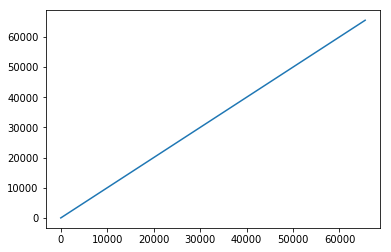

In [14]:
plt.plot(tone_curve)
plt.show()

可以看到相机色调曲线是一条直线，因此不需要进行非线性变换，但是相机记录的值并不是直接反应亮度，而是有黑色和白色阈值，需要将`black_level`和`white_level`之间的值重新缩放(rescale)到`[0,1]`范围内,同时，由于传感器噪声和过曝，实际采集到的值会超出这一范围，也需要注意进行范围裁剪操作

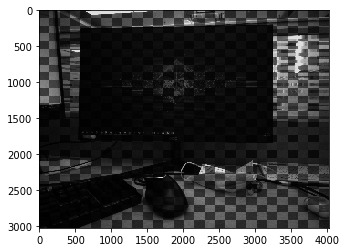

In [15]:
# 请完善这部分代码  （2分）
## 眼前的黑不是黑🎵
## 你说的白是什么白🎵

def linear_clip(raw):
    # 输入： raw:原始图片，type=numpy.array, shape=(H,W)
    # 输出： raw_clipped:经过线性化和裁剪后的图片，type=numpy.array, shape=(H,W)
    
    return raw_clipped

raw_clipped = linear_clip(raw_image)
plt.imshow(raw_clipped,cmap='gray')
plt.show()

## 2.2 去马赛克

在刚才的实验中你是否怀疑原始图片的拜尔阵列不是RGGB排列的？这一点在描述文件中可以得到解答，其中`color_desc=RGBG`，尽管看上去并非RGGB排列,实际上它只是用于定性的描述四种滤波片的颜色，而滤波片排列顺序由`raw_pattern`的一个`2*2`的矩阵决定，将RGBG沿着它所描述的0,1,2,3的顺时针顺序排列所得到的正是我们之前所定义的RGGB排列。

注意这里`num_colors=3`表示这里所用到的两个绿色滤波片`G`是相同的，没有差异。如果`num_colors=4`则表示这两种滤波片尽管都用`G`代指，但其频谱响应是不同的。事实上除了最为常见拜尔阵列，还有多种不同的阵列，如[RGBW阵列](https://zhuanlan.zhihu.com/p/84256087)通过加入无滤波的White通道使光的透传率增加 （滤波片通过阻拦波长会减小通过的光强）。不同的像感器所使用的滤波器的频率响应也不尽相同。现在想一想为什么color_matrix是一个`3*4`大小的矩阵？

在下面的代码中，应用刚才编写的`demosacing`函数恢复图片。经过线性化后之前见到的问题有改善吗？


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


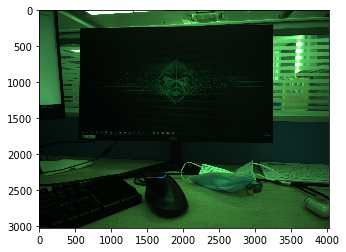

In [10]:
raw_demosac = demosiacing(raw_clipped)
plt.imshow(raw_demosac)
plt.show()

## 2.3 颜色空间校正

上面的图片是否还是偏绿色？图像颜色校正首先要进行白平衡，`camera_wb`记录了相机的白平衡参数，对于`num_colors=3`的图片，其前三个参数分别对应于RGB的增益值。需要对三个通道分别乘上其白平衡参数。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


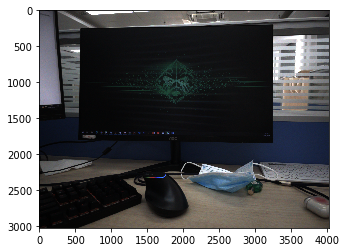

In [11]:
# 你说的天空蓝🎵
# 是我记忆中那团白云背后的蓝天🎵

raw_wb =     ## 请完成这部分代码 （2分）
plt.imshow(raw_wb)
plt.show()

上面的图片是否已经有了更有真实感的颜色？但由于相机的彩色空间(由其RGB滤波片定义)和显示时的彩色空间(如sRGB)并非同一个，需要对色彩进行变换。这个参数存储在`color_matrix`中，对于`num_colors=3`的图片，其前三列所构成的矩阵定义了从相机彩色空间到sRGB彩色空间的变换。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


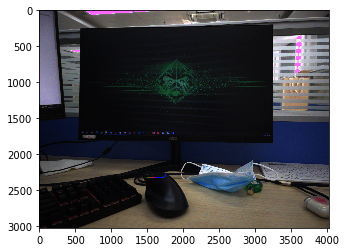

In [37]:
raw_color =  ## 请完成这部分代码  （2分）

plt.imshow(raw_color)
plt.show()

Q: 这张彩色矫正过的图片在高光区域是否有直观上的异常？你觉得是什么原因造成的？你是否有方法进行校正？ （2分）

A:

Hint: 从过曝的角度思考，考虑处理过程中图像的值域范围

In [13]:
## 请写代码校正图像，有必要的情况下可以用多个block说明,并将校正后的结果图像命名为raw_color_corr （2分）
raw_color_corr = 

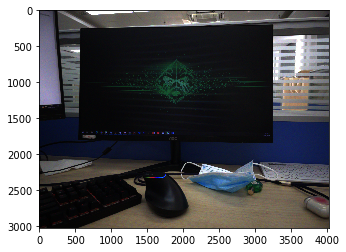

In [14]:
## 可视化校正后的图像
plt.imshow(raw_color_corr)
plt.show()

## 2.4 亮度和γ校正
现在你已经有一个颜色正确的图像了，但是由于视觉和显示的非线性，从视觉上图像还会偏暗，我们可以通过γ校正的方式来得到对应的矫正图像，具体做法是对图像中的每一个像素进行`1/2.2`的乘方操作

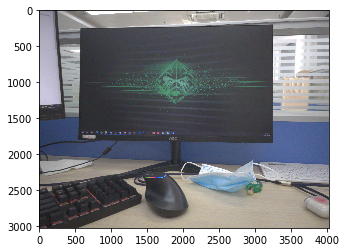

In [15]:
raw_gamma =    ## 完成代码 （2分）
plt.imshow(raw_gamma)
plt.show()

## 3 图片JPEG压缩
******
处理后的图片直接存储将占据较大空间，JPEG是通用的有损压缩格式，可以有效地减小所占用的空间。JPEG压缩包括Y'CbCr彩色空间变换、色度降采样、DCT变化、量化与霍夫曼编码几个环节。
<div style="text-align: center">
<img src="./imgs/JPEG.png" width = "800"/>
</div> 

## 3.1 彩色空间变换（RGB -> Y'CbCr）（无损）
JPEG压缩首先将图像从gamma校正后的RGB空间变换到Y'CbCr空间，其中Y'分量编码亮度，Cb,Cr分量编码色度（Cb为蓝色轴，Cr为红色轴）。
<div style="text-align: center">
<img src="./imgs/YCbCr.png" width = "800"/>
</div>

In [16]:
## 编写代码将处理后的RGB图片变换为Y'CbCr空间 (无损) (2分)
def RGB2YCbCr(rgb):
    # 输入： rgb:RGB图片，type=numpy.array, shape=(H,W,3)
    # 输出： YCbCr:转换后的YCbCr图片，type=numpy.array, shape=(H,W,3)
    mat_rgb2ycbcr = np.array([[0.299,0.587,0.114],[-0.169,-0.331,0.5],[0.5,-0.419,-0.081]])
    YCbCr =    # 完成代码 
    return YCbCr

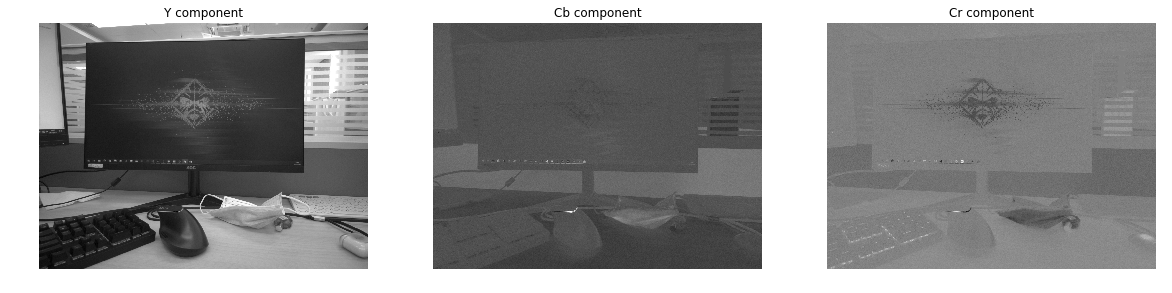

In [17]:
raw_gamma = ((raw_gamma)*255).astype(np.uint8)
H,W,_ = raw_gamma.shape
resized_gamma = cv2.resize(raw_gamma,(W//2,H//2))
img_YCbCr = RGB2YCbCr(resized_gamma)

# 图片可视化
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(img_YCbCr[:,:,0],cmap='gray'); ax.axis('off')
ax.set_title('Y component')
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(img_YCbCr[:,:,1],cmap='gray'); ax.axis('off')
ax.set_title('Cb component')
ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(img_YCbCr[:,:,2],cmap='gray'); ax.axis('off')
ax.set_title('Cr component')
plt.show()

### 3.2 色度降采样（有损）与图像分块
从上图可以看到人们对于亮度的变化是敏感的，亮度编码了重要的图像边缘等结构信息。相对而言，人们对色度的变化不太敏感，因此JPEG压缩中对色度进行了降采样。如图所示根据生成JPEG质量的不同对色度的[降采样方式](https://kns.cnki.net/kcms/detail/detail.aspx?dbcode=CJFD&dbname=CJFD2007&filename=XBGS200702001&uniplatform=NZKPT&v=PYAAoqNEauzjvT03VsHc%25mmd2FhbO3AFGiQGKJIGYtcZPrxIoEtELwZvvZjUoUphIj5NA)也不同，其中最常见的是4：2：0降采样。 这种方式并非表示对Cr不采样，而是每行间隔着对Cb和Cr采样，同时在同一行的每列也间隔采样。因此，对Y信号的采样率是Cb和Cr信号采样率的2倍。
<div style="text-align: center">
<img src="./imgs/420downsample.png" width = "800"/>
</div>

JPEG的编码是对每个`8*8`的小图像块(block)进行的。然而，由于对不同的通道可能采取的采样率不同，JPEG在编码时先将图像分解为对应的最小编码单元(Minimum Coded Unit, MCU)，以确保在MCU内所有通道(Y/Cb/Cr)都能有至少一个完整的`8*8`大小的图像块。如果是4:2:0降采样，则其对应的MCU大小就是`16*16`。（如果不降采样，则MCU大小就是`8*8`）
<div style="text-align: center">
<img src="./imgs/MCUs.png" width = "800"/>
</div>在对图像进行序列化编码时，扫描(scan)的顺序就至关重要，JPEG对MCU的扫描顺序是先横向再纵向，对于MCU内部，先按照通道Y->Cb->Cr的顺序排列，如果该通道有多个图像块,图像块之间也是先横向再纵向的方式进行扫描。

Note: 可以看到，编码后的图像其长宽都是16的整数倍，如果原图像并非整数倍，则需要对图像边缘进行填补(padding),填补是一个常见的图像边缘操作，可以补0、补常数值以及对称填补等。这里不对填补方式进行要求，但需要进行填补操作，并返回填补后新的图像长宽

In [18]:
## 编写代码进行色度降采样(有损), 并分解为分解为MCU (5分)
def spliting(ycbcr):
    # 输入: ycbcr: 三通道的YCbCr图像, type=numpy.array, shape=(H,W,3)
    # 输出: MCU_stack: 由MCU组成的矩阵，type=numpy.array, shape=(N,6,8,8) 其中N为MCU数量，6为MCU内blocks的数量，排列方式如上图所示
    #      img_size: 填补后图像大小, type=tuple
    
    return MCU_stack, img_size

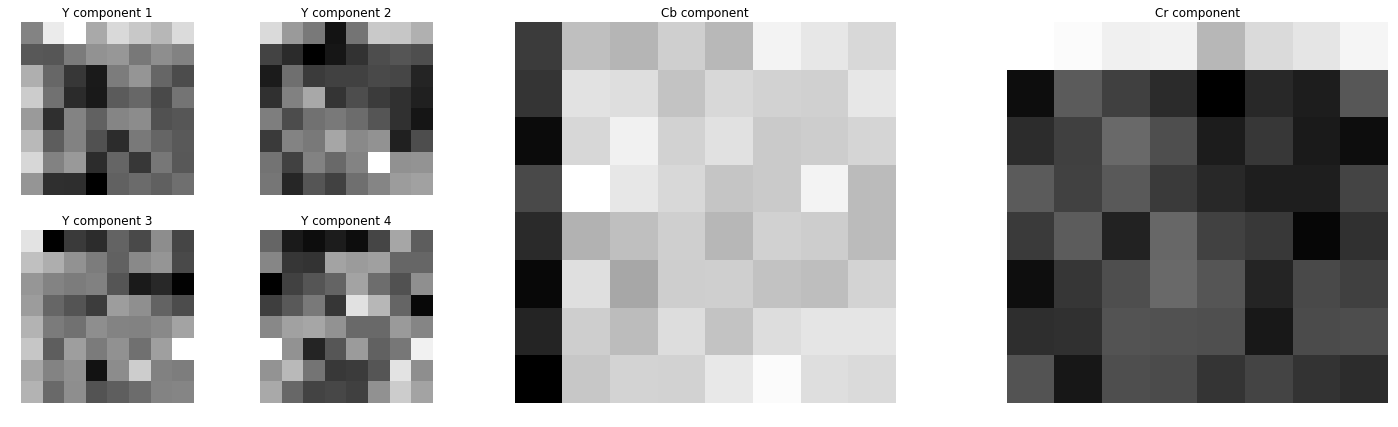

In [19]:
## 将图片分解为多个MCU 并且可视化第一个MCU
img_MCUs,img_size = spliting(img_YCbCr)
mcu=img_MCUs[0]
fig = plt.figure(figsize=(25,7))
ax = fig.add_subplot(2, 6, 1)
imgplot = plt.imshow(mcu[0],cmap='gray'); ax.axis('off')
ax.set_title('Y component 1')
ax = fig.add_subplot(2, 6, 2)
imgplot = plt.imshow(mcu[1],cmap='gray'); ax.axis('off')
ax.set_title('Y component 2')
ax = fig.add_subplot(2, 6, 7)
imgplot = plt.imshow(mcu[2],cmap='gray'); ax.axis('off')
ax.set_title('Y component 3')
ax = fig.add_subplot(2, 6, 8)
imgplot = plt.imshow(mcu[3],cmap='gray'); ax.axis('off')
ax.set_title('Y component 4')
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mcu[4],cmap='gray'); ax.axis('off')
ax.set_title('Cb component')
ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(mcu[5],cmap='gray'); ax.axis('off')
ax.set_title('Cr component')
plt.show()

### 3.3 DCT变换与量化

**3.3.1 DCT变换（无损）**

对于每一个`8*8`大小的图像块，JPEG对它做DCT变换。注意这里由于确定了滑块的长宽均为8个像素，对应的`8*8=64`个DCT基函数也随之确定下来。注意最左上的一个为直流（DC）分量的基函数，其余63个均为交流(AC)分量基函数。基函数矩阵从左上到右下频率逐渐变高。正如信号分析中常见的，图像信号中一般低频部分的系数将大于更高频部分。通过DCT分离出低频高频信息，可以针对不同频段进行不同程度的量化和编码，从而达到压缩的目的。

<div style="text-align: center">
<img src="./imgs/DCT.png" width = "800"/>
</div>


In [20]:
## DCT变换,使用默认DCT type-II 变换,变换前需要将图像shift到[-128,127]的值域范围内 (无损) (2分)
from scipy.fftpack import dctn,idctn
Yb = mcu[0]  # 取Y分量第一个block为例子
Yb_DCT =           ## 完成代码，可用dctn库
recon_residual = abs(Yb-128-idctn(Yb_DCT,norm='ortho')).sum()
print('Reconstruction residual of DCT transformation: %.2g'%recon_residual)
np.set_printoptions(precision=2,suppress=True)
print('DCT transformation of single Y block\n',Yb_DCT)

Reconstruction residual of DCT transformation: 2.1e-13
DCT transformation of single Y block
 [[107.07   1.61   3.76   4.01   0.39  -0.43   2.87   2.84]
 [  6.6   -2.07  -3.41  -1.94  -0.81  -1.93  -1.37  -1.18]
 [  4.55  -1.7   -1.    -2.81  -1.34  -1.17  -1.27   1.06]
 [  5.94   1.22  -2.19  -4.06  -1.56   1.01   0.87  -0.14]
 [  1.72  -1.31  -0.25   0.03   0.56  -1.89   0.78  -0.14]
 [  2.47   2.91   3.2    0.04  -0.85  -1.58  -0.81   0.67]
 [  0.15  -0.34   0.91   1.59  -1.19  -0.62   0.95  -1.18]
 [  1.46   0.47  -1.62   0.6   -0.49  -0.38   0.44   1.43]]


**3.3.2 量化 （有损）**

正如在DCT变换中看到的，低频分量系数大于高频。人眼对低频分量变化的敏感程度大于高频部分,根据心理视觉阈值，JPEG标准中为亮度和色度的基函数分别制定了量化表格[ITU-T.81, Annex-K, Table-K.1/2, Page-143](https://www.w3.org/Graphics/JPEG/itu-t81.pdf)，对于每个基函数，当其系数变化量为量化表格中阈值的一半时，其恢复出的图像和原图像基本没有差异。因此**量化表格中的系数给出了对每个基函数量化的精细程度，越小表示量化的精细程度越细**。可以看到，表格中的数字基本满足从坐上到右下递增的趋势，说明其重要性是从左上到右下递减的。亮度量化表格适用于Y通道，色度量化表格适用于Cb,Cr通道。
<div style="text-align: center">
<img src="./imgs/quantization.png" width = "800"/>
</div>


In [21]:
## 编程实现量化 （有损） （2分）
from utils import lumin_quant_table,chrom_quant_table # 分别载入亮度量化表和色度量化表

def quant(b_dct,isLuminance):
    # 输入： b_dct: 经过DCT变换后的block, type=numpy.array, shape=(8,8)
    #       isLuminance: 该Blok是否是亮度分量, type=bool
    # 输出： b_quant: 量化后的block, type=numpy.array, shape=(8,8),dtype=int16
    
    return b_quant

Yb_quant = quant(Yb_DCT,isLuminance=True)
print('quantized Y block:\n',Yb_quant)

quantized Y block:
 [[6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


### 3.4 霍夫曼编码
JPEG支持算数编码与霍夫曼编码，尽管算数编码从数学上比霍夫曼编码平均码率更低，但是历史上由于受专利保护以及编码解码的效率不高，实际上算数编码没有霍夫曼编码常见。一般而言通过算术编码可以使文件变小5-7%。在本例中，我们使用霍夫曼编码进行演示。实际应用中可以通过统计计算出霍夫曼编码表，也可以使用预定义好的霍夫曼编码表。注意霍夫曼编码并非直接对值进行，而是对值的类别（表示编码该值的二进制位个数）进行的。对所存储的值进行分类编码，可以看到较小的值类别更小，拥有更小的编码字长。实际上，正数的编码为其二进制表示，负数的编码是其正数编码的按位取反。

对DC编码**值类别**构成了**键码**，对AC编码，**\[0的个数，值类别\]** 的二元组构成了**键码**，所有键码都会转化为2bytes的uint16类型。

<div style="text-align: center"> 
<img src="./imgs/huffman.png" width = "800"/>
</div> 

#### 3.4.1 霍夫曼表解码
JPEG为了更紧凑的表示霍夫曼编码，在文件的描述部分使用了规范的霍夫曼树来表示霍夫曼编码表。如上述DC霍夫曼编码在二进制文件中的字节流如下图所示。其中紫色部分由16个bytes组成,用来描述编码后字长为n的**键码**各自有多少个(最长的码字为16位)。画成树状图即是每个编码层数所对应的节点数量。总共可编码的值类别数量为这16个数的总和，在这里有12个，紧跟着的12个绿色的bytes则表示这12个**键码**依次是哪些。
<div style="text-align: center"> 
<img src="./imgs/huffman_decode.png" width = "800"/>
</div>
由于霍夫曼编码并不唯一，这里使用的规范化编码可以想象成把所有编码尽可能向上(编码1的方向)移动，因此，只需要记录每一层的节点数和节点的顺序即可存下整个规范化霍夫曼编码。对霍夫曼表的解码可以根据以下原则进行：

1. 层数最低的第一个叶节点码值是0,位数是其层数，因此第一个编码`0`类别的叶节点是`00`
2. 假设前一个叶节点码值为n,当前叶节点的层数与上一个叶节点的层数差值为x，则前叶节点的码值为$(n+1)*(2^x)$(如果同层就是$n+1$)。码字的位数由其层数决定，前面的`0`不可省略

Note:
1. 这里的`0A`、`0B`为10和11的16进制编码。
2. 本段中使用[bitstream](https://boisgera.github.io/bitstream/)作为比特流的读写工具

In [17]:
## 解码霍夫曼表  （5分）

def stream_code(len,code_word):
    # 将一个uint16类型的数转换为指定长度的比特流（不省略指定长度中前面的0）
    # 输入： len: 比特流的长度，type=int
    #       code_word: 待转化的码字值，type=uint16
    # 输出： stream：转化后的比特流，type=bitstream.BitStream
    stream = BitStream()
    stream.write(code_word,np.uint16)
    stream.read(bool,16-len)
    return stream

def map_from_HT(huffman_table):
    # 输入： huffman_table: 原始霍夫曼表，type=list,type(element)=uint16
    # 输出： mapping: 从[键码]到[霍夫曼二进制编码]的mapping，type=dict, type(key)=uint16, type(value)=bitstream.BitStream

    return mapping


In [18]:
from utils import STD_HUFTAB_CHROM_AC,STD_HUFTAB_CHROM_DC,STD_HUFTAB_LUMIN_AC,STD_HUFTAB_LUMIN_DC

## 解码标准霍夫曼表
STD_HUFTAB_LUMIN_DC_MAP = map_from_HT(STD_HUFTAB_LUMIN_DC) # 标准亮度DC霍夫曼表
STD_HUFTAB_LUMIN_AC_MAP = map_from_HT(STD_HUFTAB_LUMIN_AC) # 标准亮度AC霍夫曼表
STD_HUFTAB_CHROM_DC_MAP = map_from_HT(STD_HUFTAB_CHROM_DC) # 标准色度DC霍夫曼表
STD_HUFTAB_CHROM_AC_MAP = map_from_HT(STD_HUFTAB_CHROM_AC) # 标准色度AC霍夫曼表

print('huffman mapping for DC luminance\n',STD_HUFTAB_LUMIN_DC_MAP)

huffman mapping for DC luminance
 {0: 00, 1: 010, 2: 011, 3: 100, 4: 101, 5: 110, 6: 1110, 7: 11110, 8: 111110, 9: 1111110, 10: 11111110, 11: 111111110}


#### 3.4.2 DC分量编码

需要注意的是，直流（DC）分量的处理与交流(AC)分量不同，由于DC分量反应了小图像块的平均亮度，本身一般具有较大的幅值，而相邻图像块之间的变化则相对较小，JPEG选择编码相邻图像块间DC分量的插值来提高编码效率（第一个图像块由于没有前序图像块，所以直接用自己而非差值来编码）。DC分量值的编码由两部分组成，第一部分是值的类别，第二部分是值的类内编码。

假设第一个图像块的DC分量为`127`，第二个图像块的DC分量为`125`，则对第一个图像块的DC分量`127`其类别为`7`,表示通过一个7位二进制数值表示编码，类内编码为`1111111`，从第二张霍夫曼编码可以得到类别`7`的编码为`11110`，所以总的编码为`111101111111`；第二个图像块编码DC分量差值`125-127=-2`,其类别为`2`，表示通过一个2位二进制表示编码，类内编码为`01`,类别`2`的霍夫曼编码为`011`,总的编码为`01101`。

In [24]:
## 完成DC编码   （5分）

def value_code(value):
    # 对值的分类编码，对应于3.4最左侧图
    # 输入： value: 需要被编码的值, type=int16
    # 输出： cat: 值所属的类别(category), type=int. 如value=6 对应的cat=3
    #       stream: 值所对应的类内二进制编码，type=bitstream.BitStream. 如value=6 对应的stream=110
    
    return cat, stream

def dc_encode(value,isLuminance):
    # 输入： value: 需要被编码的DC值, type=int16
    #       isLuminance: 该DC值是否是亮度分量, type=bool
    # 输出： dc_code: DC值所对应的DC编码,由类别的霍夫曼编码与类内编码组成, type=bitstream.BitStream, 如value=6, isLuminance=True 对应的dc_code=100110
    
    return dc_code

In [25]:
for value in [127,-2,0]:
    print('DC code for',value,' is:',dc_encode(value,isLuminance=1))

DC code for 127  is: 111101111111
DC code for -2  is: 01101
DC code for 0  is: 00


#### 3.4.2 AC分量编码
AC分量的编码同样由两部分组成，第一部分为游程与AC值类别的霍夫曼编码，第二部分为值的二进制编码。

**游程编码 （Run Length Encoding）**
由于量化后的图像块大部分都是0值，特别是高频成分很少具有1，JPEG不直接对像素值编码，而是用一个二元组记录每次出现非零值之前0值出现的次数和非零值大小。对于图像的二维序列，JPEG首先进行`Zigzag`扫描将矩阵展开成一维数组，从而进行游程编码。如图中在`zigzag`一维展开后的数组，第一个987前没有0，将他编码成`(0,987)`,第一个62前有一个0，则将它编码成`(1,62)`，以此类推。

三个需要注意的地方：
1. 当编码完最后一个非零值后，如果还没有到达最后一个值剩余的部分可以用一个特殊的二元组`(0,0)`表示“剩下的都是0”，这个特殊二元组也被称为EOB(end of bytes)。**如果最后一个值非零，则不再添加(0,0)**
2. 如果中间连续0的个数大于15个，需要插入一个特殊的`（15,0）`来表示有16个连续的0，这是由于位置编码时仅用了4bit编码而导致的妥协方案。如本图中`(31,1)`就需要被拆分为`(15,0)`和`(15,1)`
3. 直流(DC)分量与交流(AC)分量编码不同，游程编码在JPEG编码中主要编码AC分量，因此对于最左上角的DC分量可以不采用游程编码，只对剩余部分编码

<div style="text-align: center">
<img src="./imgs/zigzag.png" width = "800"/>
</div>


In [26]:
## 请完成代码 (6分)

                
def rle(dct_quant):
    # 输入: dct_quant:  AC量化后DCT图像块, type=numpy.array, shape=(8,8)
    # 输出: rle_coding: 游程编码, type=list, 如上例输出应该为[[0,386],[0,-187],......,[15,0],[15,1],[0,0]]
    
    return rle_coding
    

In [27]:
## 测试RLE
sample_patch = np.zeros((8,8),dtype=int)
sample_patch[[0,0,0,0,1,1,1,2,2,2,3,3,6],[0,1,2,4,0,2,4,0,1,3,1,2,4]]=[987,-386,62,-55,-187,148,-58,48,70,-58,-52,-43,1]

rle_patch = rle(sample_patch)
print('sample patch\n',sample_patch)
print('RLE for sample patch:\n',rle_patch)

## 如果末尾分量非零，则不应再添加[0,0]
sample_patch[7,7]=1
rle_patch = rle(sample_patch)
print('RLE for non-negative tail sample patch:\n',rle_patch)

sample patch
 [[ 987 -386   62    0  -55    0    0    0]
 [-187    0  148    0  -58    0    0    0]
 [  48   70    0  -58    0    0    0    0]
 [   0  -52  -43    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    0    0]]
RLE for sample patch:
 [[0, -386], [0, -187], [0, 48], [1, 62], [1, 148], [0, 70], [2, -52], [2, -55], [1, -58], [0, -58], [0, -43], [15, 0], [15, 1], [0, 0]]
RLE for non-negative tail sample patch:
 [[0, -386], [0, -187], [0, 48], [1, 62], [1, 148], [0, 70], [2, -52], [2, -55], [1, -58], [0, -58], [0, -43], [15, 0], [15, 1], [12, 1]]


**AC完整编码：** 经过游程编码后，首先对其值部分进行分类编码，获得其值的类别后，将游程与值类别组成的组合进行霍夫曼编码，同样的可以通过预定义的霍夫曼编码表进行编码。最后加上其值的类内编码组成完整的AC编码。`[0,-9]`为例，其值`-9`的类别为`4`,因此，对`[0,4]`这样的一个二元组查询**亮度AC霍夫曼编码表（3.4最右侧）** 可以得到对应的编码为`1011`,`-9`的类内编码为`0110`,因此完整的AC编码为`10110110`。同样的,查表得到对`[1,3]`的编码为`1101111`，`[0,0]`的编码为`1010`。

note: 注意对于AC编码，首先将`[0的数量，值的类别]`这样的一个二元组组合为一个uint16类型的key进行查表,高8位表示`"0的个数"` ,低8位表示`"值的类别"`。如`[1,3]`被转化为`19`。

In [28]:
## 完成下列代码 （2分）

def ac_encode(rle_pair,isLuminance):
    # 输入： rle_pair: 需要被编码的AC游程二元组, type=list, 如[0,-9]
    #       isLuminance: 该AC游程二元组是否是亮度分量, type=bool
    # 输出： ac_code: AC游程二元组所对应的AC编码,由[游程,值类别]的霍夫曼编码与值的类内编码组成, type=bitstream.BitStream,
    #                rle_pair=[0,-9], isLuminance=True 对应的ac_code=10110110
    
    return ac_code


In [29]:
for rle_pair in [[0,-9],[1,3],[0,0]]:
    print('AC code for',rle_pair,' is:',ac_encode(rle_pair,isLuminance=1))

AC code for [0, -9]  is: 10110110
AC code for [1, 3]  is: 1101111
AC code for [0, 0]  is: 1010


### 3.5 分块聚合
恭喜，JPEG的所有分块编码部分已经完成了，最后需要遍历图像的所有MCU形成完整的图像编码。在这个过程中，需要特别注意对DC分量的**差值**进行编码。每个MCU由4个亮度图像块和两个色度图像块组成，在编码中顺序进行编码，每个图像块先编码DC差值分量，然后是AC分量。不同通道(Y/Cb/Cr)之间的DC不做差值，而是需要跳过其他的通道对上一个的本通道图像块进行DC差值，如图所示。
<div style="text-align: center">
<img src="./imgs/MCU_stacking.png" width = "800"/>
</div>

In [30]:
# 完成代码 (5分)

def encode_MCUs(img_MCUs):
    # 输入： img_MCUs:由图像MCU组成的矩阵，type=numpy.array, shape=(N,6,8,8) 其中N为MCU数量，6为MCU内blocks的数量
    # 输出： img_data:对整个图像的完整二进制编码,type=bitstream.BitStream
    
    return img_data


In [31]:
from utils import write_JPEG
img_data = encode_MCUs(img_MCUs)

## 压缩比计算
coded_length = img_data.__len__() //8 # 编码后长度，单位bytes
original_length = H*W*3       # 编码前长度，单位bytes, 假设图片存储格式为uint8
print('compress_rate:%.2f%%'%(coded_length/original_length*100))

write_JPEG('output_image.jpg',img_data,img_size,\
                ht_dc_lumin=STD_HUFTAB_LUMIN_DC,ht_ac_lumin=STD_HUFTAB_LUMIN_AC,\
                ht_dc_chrom=STD_HUFTAB_CHROM_DC,ht_ac_chrom=STD_HUFTAB_CHROM_AC,\
                qt_lumin=lumin_quant_table,qt_chrom=chrom_quant_table) # 将生成的图像写入jpg文件,注意放入对应的霍夫曼编码表

compress_rate:0.29%


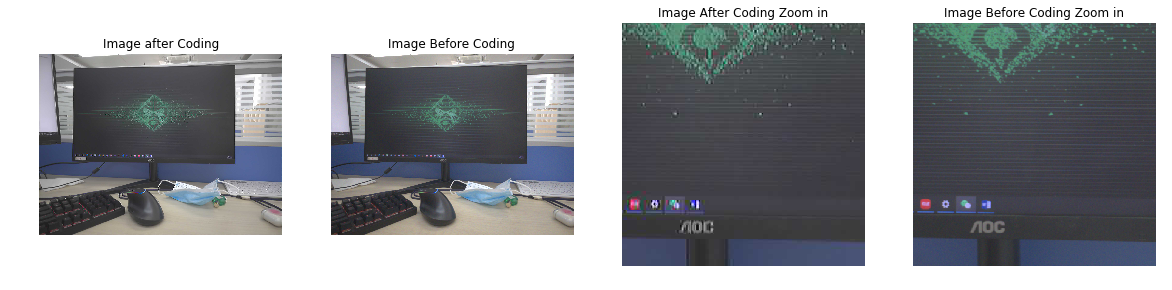

evaluation of reconstruction are measured by comapring reconstruted and initial RGB image 
 PSNR: 31.254636333029225   SSIM: 0.8213581597737732


In [32]:
output_image = imageio.imread('output_image.jpg') 
H,W,_ = resized_gamma.shape
output_image=output_image[:H,:W] # crop to same dimension

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(output_image)
ax.set_title('Image after Coding'); ax.axis('off')
ax = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(resized_gamma); ax.axis('off')
ax.set_title('Image Before Coding')
ax = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(output_image[H//2-200:H//2+200,W//2-200:W//2+200]); ax.axis('off')
ax.set_title('Image After Coding Zoom in')
ax = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(resized_gamma[H//2-200:H//2+200,W//2-200:W//2+200]); ax.axis('off')
ax.set_title('Image Before Coding Zoom in')
plt.show()

psnr = peak_signal_noise_ratio(output_image,resized_gamma)
ssim = structural_similarity(output_image,resized_gamma,multichannel=True)
print('evaluation of reconstruction are measured by comapring reconstruted and initial RGB image \n PSNR:',psnr, '  SSIM:',ssim)



对比编码前的图片，图像恢复的效果是否令人满意？你有什么方式可以使效果更好？或者能否使压缩效率更高？

In [33]:
## （加分项，最高可加12分）
## 添加你的代码使改善编码后图片质量或者提高压缩效率
## 根据实现的效果和难度进行加分
## 注意：如果需要使用算术编码、更改降采样方式、更改霍夫曼编码表、更改量化编码表，
##       则在调用write_JPEG写入jpg文件时需要指定相应的信息，可以搭配write_JPEG代码和参考Ref中的JPEG文件格式详解使用

**Ref:**

1. [RAW Guide](https://rcsumner.net/raw_guide/RAWguide.pdf)
2. [rawpy's Documentation](https://letmaik.github.io/rawpy/api/)
3. [Simple JPEG Library](https://koushtav.me/jpeg/tutorial/2017/11/25/lets-write-a-simple-jpeg-library-part-1/)
4. [JPEG Wikipedia](https://en.wikipedia.org/wiki/JPEG)
5. [JPEG 文件格式详解](https://segmentfault.com/a/1190000021169775)
6. [JPEG 用python解码](https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python/)
7. [跟着我写JPEG解码器-读取huffman-table](https://github.com/MROS/jpeg_tutorial/blob/master/doc/%E8%B7%9F%E6%88%91%E5%AF%ABjpeg%E8%A7%A3%E7%A2%BC%E5%99%A8%EF%BC%88%E4%B8%89%EF%BC%89%E8%AE%80%E5%8F%96%E9%87%8F%E5%8C%96%E8%A1%A8%E3%80%81%E9%9C%8D%E5%A4%AB%E6%9B%BC%E8%A1%A8.md)